In [2]:
import torchphysics as tp
import numpy as np
import torch
from matplotlib import pyplot as plt

# Physics Informed Neural Networks (PINNs) in TorchPhysics
In this tutorial we present a first basic example of solving a PDE with boundary constraints in TorchPhysics using a PINN approach.
You will also learn about the different components of this library and main steps for finding a neural network that approximates the solution of a PDE.

We want to solve the time-dependent heat equation for a perfectly insulated room $\Omega\subset \mathbb{R}^2$ in which a heater is turned on.
$$
\begin{cases}
\frac{\partial}{\partial t} u(x,t) &= \Delta_x u(x,t) &&\text{ on } \Omega\times I, \\
u(x, t) &= u_0 &&\text{ on } \Omega\times \{0\},\\
u(x,t) &= h(t) &&\text{ at } \partial\Omega_{heater}\times I, \\
\nabla_x u(x, t) \cdot \overset{\rightarrow}{n}(x) &= 0 &&\text{ at } (\partial \Omega \setminus \partial\Omega_{heater}) \times I.
\end{cases}
$$
The initial room (and heater) temperature is $u_0 = 16$. The time domain is the interval $I = (0, 20)$, whereas the domain of the room is $\Omega=(5,0) \times (4,0)$. The heater is located at $\partial\Omega_{heater} = [1,3] \times \{4\}$ and the temperature of the heater is described by the function $h$ defined below.
The normal vector at some $x\in \partial \Omega$ is denoted by $\overset{\rightarrow}{n}(x)$.

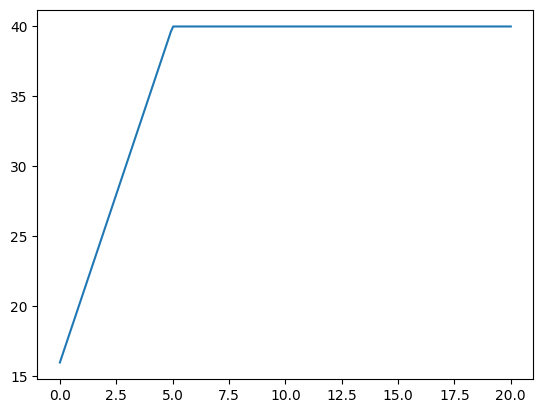

In [3]:
u_0          = 16 # initial temperature
u_heater_max = 40 # maximal temperature of the heater
t_heater_max = 5  # time at which the heater reaches its maximal temperature

# heater temperature function
def h(t):
    ht = u_0 + (u_heater_max - u_0) / t_heater_max * t
    ht[t>t_heater_max] = u_heater_max
    return ht

# Visualize h(t)
t = np.linspace(0, 20, 200)
plt.plot(t, h(t))
plt.show()

## Recall PINNs
The goal is to find a neural network $u_\theta: \overline{\Omega\times I} \to \mathbb{R}$, which approximately satisfies all four conditions of the PDE problem above, where $\theta$ are the trainable parameters of the neural network.
Let us shortly recall the main idea behind PINNs.

In our case, there is no data available (e.g. temperature measurements in $\Omega$), which could be used for training the neural network. Hence, we can only exploit the four conditions listed above.

The residuals are denoted by
$$
\begin{align}
&\text{1) Residual of pde condition: }      &&R_1(u, x, t) := u(x, t) - \Delta_x u(x,t) \\
&\text{2) Residual of initial condition: }  &&R_2(u, x) := u(x, 0) - u_0\\
&\text{3) Residual of dirichlet boundary condition: }  &&R_3(u, x, t) := u(x,t) - h(t)\\
&\text{4) Residual of neumann boundary condition: }    &&R_4(u, x, t) :=\nabla_x u(x,t) \cdot \overset{\rightarrow}{n}(x)
\end{align}
$$
Continuing with the PINN approach, points are sampled in the domains corresponding to each condition. In our example points
$$
\begin{align}
&\text{1) } &&\big(x^{(1)}_i, t_i^{(1)} \big)_i &&&\in \Omega \times I,\\
&\text{2) } &&\big(x^{(2)}_j, 0 \big)_j        &&&\in \Omega \times \{0\},\\
&\text{3) } &&\big(x^{(3)}_k, t_k^{(3)} \big)_k &&&\in \partial\Omega_{heater} \times I,\\
&\text{4) } &&\big(x^{(4)}_l, t_l^{(4)} \big)_l &&&\in (\partial\Omega \setminus \partial\Omega_{heater}) \times I.
\end{align}
$$
Then, the network $u_\theta$ is trained by solving the following minimization problem
$$
\begin{align}
\min_\theta \sum_{i} \big\vert R_1(u_\theta, x^{(1)}_i, t_i^{(1)}) \big \vert^2 + \sum_j \big\vert R_2(u_\theta, x^{(2)}_j) \big \vert^2 + \sum_k \big\vert R_3(u_\theta, x^{(3)}_k, t_k^{(3)}) \big \vert^2 + \sum_l \big\vert R_4(u_\theta, x^{(4)}_l, t_l^{(4)}) \big \vert^2,
\end{align}
$$
that is, the residuals are minimized with respect to the $l_2$-norm.
It is to be noted here that if data was available, one could simply add a data loss term to the loss function above.

## Translating the PDE Problem into the Language of TorchPhysics
Translating the PDE problem into the framework of TorchPhysics works in a convenient and intuitive way, as the notation is close to the mathematical formulation. The general procedure can be devided into five steps. Also when solving other problems with TorchPhysics, such as parameter identification or variational problems, the same steps can be applied, see also the further [tutorials](https://boschresearch.github.io/torchphysics/tutorial/tutorial_start.html) or [examples](https://boschresearch.github.io/torchphysics/examples.html).

### Step 1: Specify spaces and domains
The spatial domain $\Omega$ is a subset of the space $\mathbb{R}^2$, the time domain $I$ is a subset of $\mathbb{R}$, whereas the temperature $u(x,t)$ attains values in $\mathbb{R}$. First, we need to let TorchPhysics know which spaces and domains we are dealing with and how variables/elements within these spaces are denoted by.
This is realized by generating objects of TorchPhysics' Space and Domain classes in "tp.spaces" and "tp.domains", respectively.
Some simple domains are already predefined, which will be sufficient for this tutorial. For creating complexer domains please have a look at the [domain-tutorial](https://boschresearch.github.io/torchphysics/tutorial/tutorial_domain_basics.html).

In [4]:
# Input and output spaces
X = tp.spaces.R2(variable_name='x')
T = tp.spaces.R1('t')
U = tp.spaces.R1('u')

# Domains
Omega = tp.domains.Parallelogram(space=X, origin=[0,0], corner_1=[5,0], corner_2=[0,4])
I     = tp.domains.Interval(space=T, lower_bound=0, upper_bound=20)

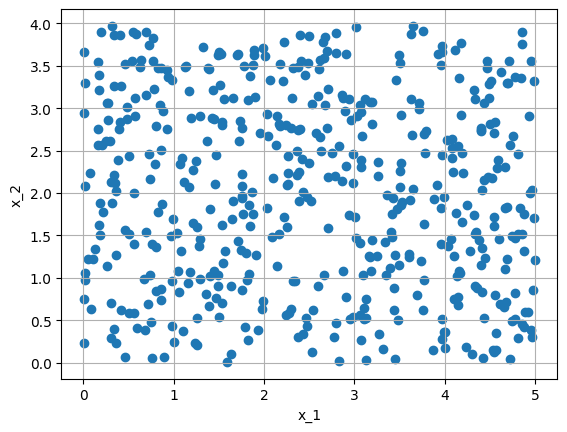

In [5]:
# The domain can be visualized by creating a sampler object, see also step 2, and use the scatter plot function from tp.utils.
Omega_sampler = tp.samplers.RandomUniformSampler(Omega, n_points=500)
plot           = tp.utils.scatter(X, Omega_sampler)

### Step 2: Define point samplers for different subsets of $\overline{\Omega\times I}$
As mentioned in the PINN recall, it will be necessary to sample points in different subsets of the full domain $\overline{\Omega\times I}$. TorchPhysics provides this functionality by sampler classes in "tp.samplers". For simplicity, we consider only Random Uniform Samplers for the subdomains. However, there are many more possibilities to sample points in TorchPhysics, see also [sampler-tutorial](https://boschresearch.github.io/torchphysics/tutorial/sampler_tutorial.html).

The most important inputs of a sampler constructor are the "domain" from which points will be sampled, as well as the "number of points" drawn every time the sampler is called. It is reasonable to create different sampler objects for the different conditions of the pde problem, simply because the subdomains differ.

For instance, the pde condition 1) should hold for points in the domain $\Omega \times I$. We have already created $\Omega$ and $I$ as TorchPhysics Domains in Step 1. Their cartesian product is simply obtained by the multiplication operator "$*$":

In [6]:
domain_pde_condition = Omega * I

Having the relevant domain on hand, we initialize as follows:

In [7]:
sampler_pde_condition = tp.samplers.RandomUniformSampler(domain=domain_pde_condition, n_points=1500)

There is an important alternative way of creating a sampler for a cartesian product of domains. Instead of defining the sampler on $\Omega\times I$, it is also possible to create samplers on $\Omega$ and $I$ seperately, and multiply the samplers instead. This might be useful if different resolutions shall be considered, or when using other samplers in TorchPhysics such as a GridSampler, since a GridSampler cannot directly be created on a cartesian product in the way above.

In [8]:
sampler_Omega                     = tp.samplers.GridSampler(domain=Omega, n_points=1000)
sampler_I                         = tp.samplers.RandomUniformSampler(domain=I, n_points=500)
alternative_sampler_pde_condition = sampler_Omega * sampler_I

For more detailed information on the functionality of TorchPysics samplers, please have a look at the [examples](https://boschresearch.github.io/torchphysics/examples.html) or [sampler-tutorial](https://boschresearch.github.io/torchphysics/tutorial/sampler_tutorial.html).

Next, let us define samplers for the initial and boundary conditions. Regarding the initial condition the domain is $\Omega \times \{0\}$, so we need access to the left boundary of the time interval $I$. All tp.domains.Interval objects have the attribute "left_boundary", an instance of TorchPhysics BoundaryDomain class, a subclass of the Domain class.

In [9]:
domain_initial_condition  = Omega * I.boundary_left
sampler_initial_condition    = tp.samplers.RandomUniformSampler(domain_initial_condition, 2500)

Both the  Dirichlet and Neumann boundary conditions should hold on subsets of the boundary $\partial \Omega \times I$. It is easier to use a sampler for the whole boundary and determine later (in Step 3, the definition of the residual functions) whether a sampled point belongs to the domain $\partial \Omega_{heater}\times I$ of the Dirichlet condition, or to the domain $(\partial \Omega \setminus \partial \Omega_{heater}) \times I$ of the Neumann condition.

In [10]:
domain_boundary_condition  = Omega.boundary * I
sampler_boundary_condition = tp.samplers.RandomUniformSampler(domain_boundary_condition, 2500)

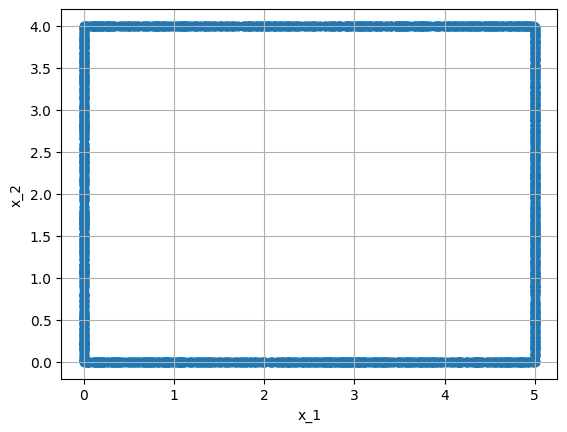

In [11]:
# Visualization of sampled points at the boundary
plot = tp.utils.scatter(X, sampler_boundary_condition)

### Step 3: Define residual functions
As mentioned in the PINNs Recall, we are looking for a neural network $u_\theta$ for which all of the residual functions $R_1,...,R_4$ vanish.

Let us have a look at $R_1$, the residual for the pde condition, the way it is defined in the PINNs Recall above. The inputs of $R_1$ are spatial and temporal coordinates $x\in \Omega$, $t\in I$, but also the temperature $u_\theta$, which is itself a function of $x$ and $t$. In TorchPhysics, the evaluation of the network $u_\theta$ at $(x,t)$ is done before evaluating the residual functions. This means that from now on we consider $R_1$ as well as the other residuals to be functions, whose inputs are triples $(u, x, t)$, where $u:=u_\theta(x,t)$.

More precisely, $u$ will be a torch.tensor of shape (n_points, 1), $x$ of shape (n_points, 2) and $t$ of shape (n_points, 1), where n_points is the number of triples $(u,x,t)$ for which the residual should be computed.

For the residual $R_1$ it is required to compute the laplacian of $u$ with respect to $x$, as well as the gradient with respect to $t$. These differential operators, among others - see [utils-tutorial](https://boschresearch.github.io/torchphysics/tutorial/differentialoperators.html), are pre-implemented and can be found in "tp.utils". The intern computation is build upon torch's autograd functionality.

In [12]:
def residual_pde_condition(u, x, t):
    return tp.utils.laplacian(u, x) - tp.utils.grad(u, t)

For the computation of the residual $R_2$ of the initial condition, the coordinates $x$ and $t$ are not required, since $u$ is already the evaluation of the network at these points. Therefore, we can conveniently omit them as input parameters.

In [13]:
def residual_initial_condition(u):
    return u - u_0

In Step 2, we defined a boundary sampler for $\partial \Omega \times I$, the domain for the boundary conditions. Hence, the sampler does not differ between the domain of the Dirichlet and Neumann boundary conditions. This is why we define a combined residual function $R_b$ for $R_3$ and $R_4$, which will output
$$
\begin{align}
R_b(u, x, t) = \begin{cases}
R_3(u, x, t) &\text{ if } &&x \in \partial \Omega_{heater},\\
R_4(u, x, t) &\text{ if } &&x \in \partial \Omega \setminus \partial \Omega_{heater}.
\end{cases}
\end{align}
$$
Let us start with the defintion of the Dirichlet residual $R_3$:

In [14]:
def residual_dirichlet_condition(u, t):
    return u - h(t)

For the Neumann residual $R_4$ we need the normal derivative of $u$ at $x$. This differential operator is also contained in "tp.utils", whereas the normal vectors at points $x\in \partial \Omega$ are available by the attribute "normal" of the "boundary" of the domain $\Omega$.

In [15]:
def residual_neumann_condition(u, x):
    normal_vectors    = Omega.boundary.normal(x)
    normal_derivative = tp.utils.normal_derivative(u, normal_vectors, x)
    return normal_derivative

The combined boundary residual $R_b$ is then easily obtained as follows:

In [16]:
def residual_boundary_condition(u, x, t):
    # Create boolean tensor indicating which points x belong to the dirichlet condition (heater location)
    heater_location           = (x[:, 0] >= 1 ) & (x[:, 0] <= 3) & (x[:, 1] >= 3.99)
    # First compute Neumann residual everywhere, also at the heater position
    residual                  = residual_neumann_condition(u, x)
    # Now change residual at the heater to the Dirichlet residual
    residual_h                = residual_dirichlet_condition(u, t)
    residual[heater_location] = residual_h[heater_location]
    return residual

### Step 4: Define Neural Network
At this point, let us define the model $u_\theta:\overline{\Omega\times I}\to \mathbb{R}$. This task is handled by the TorchPhysics Model class, which is contained in "tp.models". It inherits from the torch.nn.Module class from Pytorch, which means that building own models can be achieved in a very similar way, see [model-tutorial](https://boschresearch.github.io/torchphysics/tutorial/model_creation.html).
There are also a bunch of predefined neural networks or single layers available, e.g. fully connected networks (FCN) or normalization layers, which are subclasses of TorchPhysics' Model class.
In this tutorial we consider a very simple neural network, constructed in the following way:

We start with a normalization layer, which maps points $(x,t)\in \overline{\Omega\times I}\subset \mathbb{R}^3$ into the cube $[-1, 1]^3$.

In [17]:
normalization_layer = tp.models.NormalizationLayer(Omega*I)

Afterwards, the scaled points will be passed through a fully connected network. The constructor requires to include the input space $X\times T$, output space $U$ and ouput dimensions of the hidden layers. Remember the definition of the TorchPyhsics spaces $X,T$ and $U$ from Step 1. Similar as for domains, the cartesian product of spaces is obtained by the multiplication operator "$*$". Here, we consider a fully connected network with four hidden layers, the latter consisting of $80, 50, 50$ and $50$ neurons, respectively.

In [18]:
fcn_layer           = tp.models.FCN(input_space=X*T, output_space=U, hidden = (80,50,50,50))

Similar to Pytorch, the normalization layer and FCN can be concatenated by the class "tp.models.Sequential":

In [19]:
model               = tp.models.Sequential(normalization_layer, fcn_layer)

### Step 5: Create TorchPhysics Conditions
Let us sum up what we have done so far: For the pde, initial and combined boundary condition of the PDE problem, we constructed samplers and residuals on the corresponding domains.
Moreover, we have defined a neural network which will later be trained to fulfull each of these conditions.

As a final step, we collect these constructions for each condition in an object of the TorchPhysics Condition class, contained in "tp.conditions".
Since we are interested in applying a PINN approach, we create objects of the subclass PINNCondition, which automatically contains the information that the residuals should be minimized in the squared $l_2$-norm, see again the PINN Recall. For other TorchPhysics Conditions one may need to specify which norm should be taken of the residuals, see [condition-tutorial](https://boschresearch.github.io/torchphysics/tutorial/condition_tutorial.html) for further information.

In [20]:
pde_condition      = tp.conditions.PINNCondition(module     =model,
                                                 sampler    =sampler_pde_condition,
                                                 residual_fn=residual_pde_condition)

initial_condition  = tp.conditions.PINNCondition(module     =model,
                                                 sampler    =sampler_initial_condition,
                                                 residual_fn=residual_initial_condition)

boundary_condition = tp.conditions.PINNCondition(module     =model,
                                                 sampler    =sampler_boundary_condition,
                                                 residual_fn=residual_boundary_condition)

It is to be noted that TorchPhysics' Condition class is a subclass of the torch.nn.Module class and its forward() method returns the current loss of the respective condition.
For example, calling forward() of the pde_condition at points $(x_i, t_i)_i$ in $\Omega\times I$ will return
$$
\begin{align}
\sum_i \big \vert R_1(u_\theta, x_i, t_i) \big \vert^2,
\end{align}
$$
where $R_1$ is the residual function for the pde condition defined in the PINN recall and $u_\theta$ is the model defined in Step 4.

The reason that also the model is required for initializing a Condition object is, that it could be desireable in some [cases](https://github.com/boschresearch/torchphysics/blob/main/examples/pinn/interface-jump.ipynb) to train different networks for different conditions of the PDE problem.

## Training based on Pytorch Lightning
In order to train a model, TorchPhysics makes use of the Pytorch Lightning library, which hence must be imported. Further, we import "os" so that GPUs can be used for the calculations.

In [21]:
import pytorch_lightning as pl
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" if torch.cuda.is_available() else "0"

print ("GPU available: " + str(torch.cuda.is_available()))

GPU available: False


For the training process, i.e. the minimization of the loss function introduced in the PINN recall, TorchPhysics provides the Solver class. It inherits from the pl.LightningModule class and is compatible with the TorchPhysics library. The constructor requires a list of TorchPhysics Conditions, whose parameters should be optimized during the training.

In [22]:
training_conditions = [pde_condition, initial_condition, boundary_condition]

By default, the Solver uses the Adam Optimizer from Pytorch with learning rate $lr=0.001$ for optimizing the training_conditions. If a different optimizer or choice of its arguments shall be used, one can collect these information in an object of TorchPhysics' OptimizerSetting class. Here we choose the Adam Optimizer from Pytorch with a learning rate $lr=0.002$.

In [23]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0005)

Finally, we are able to create the Solver object, a Pytorch Lightning Module.

In [24]:
solver = tp.solver.Solver(train_conditions=training_conditions, optimizer_setting=optim)

Now, as usual, the training is done with a Pytorch Lightning Trainer object and its fit() method.

In [25]:
# Start the training
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

trainer = pl.Trainer(devices=1, accelerator=accelerator, # what to use to solve problem and how many devices
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=5000, # number of training steps
                     logger=False,
                     enable_checkpointing=False)

trainer.fit(solver) # start training

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type       | Params | Mode 
--------------------------------------------------------
0 | train_conditions | ModuleList | 9.5 K  | train
1 | val_conditions   | ModuleList | 0      | train
--------------------------------------------------------
9.5 K     Trainable params
0         Non-trainable params
9.5 K     Total params
0.038     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=5000` reached.


You can also re-run the last three blocks with a smaller learning rate to further decrease the loss.

Of course, the state dictionary of the model can be saved in the common way: torch.save(model.state_dict(), 'sd')

## Visualization
Torchphysics provides built-in functionalities for visualizing the outcome of the neural network.
As a first step, for the 2D heat equation example one might be interested in creating a contour plot for the heat distribution inside of the room at some fixed time.

For this purpose, we use the plot() function from "tp.utils", which is built on the Matplotlib library. The most important inputs are:
1) model: The neural network whose output shall be visualized.
2) plot_function: Will be applied to the model's output before visualization. E.g. if the output was two-dimensional, the plot_function $u\mapsto u[:, 0]$ could be used for showing only its first coordinate.
3) point_sampler: A sampler creating points the neural network will be evaluated at for creating the plot.
4) plot_type: Specify what kind of plot should be created.

Let us start with the sampler. The samplers we have seen so far (RandomUniformSampler, GridSampler) plot either on the interior or the boundary of their domain.
However, it is desirable to consider both the interior and the boundary points in the visualization. For this, one can use a PlotSampler, which is desined for harmonizing with plotting duties.

We wish to visualize the heat distribution in $\overline{\Omega}$ at some fixed time $t'=0$. The latter can be added to the attribute "data_for_other_variables" of the PlotSampler.

In [26]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=Omega, n_points=600, data_for_other_variables={'t':0.})

In our case, the model's output is a scalar and we do not want to modify it before plotting. Hence, plot_function should be the identity mapping. As we wish to use a colormap/contour plot to visualize the heat in $\Omega$, we specify the plot_type as 'contour_surface'.

Finally, we obtain the desired plot at time $t'=0$ by

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


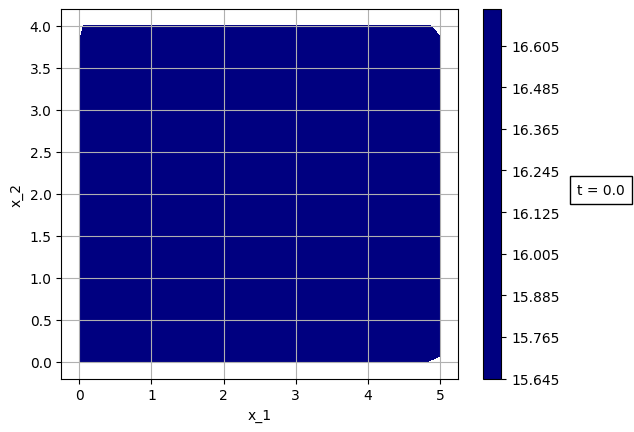

In [27]:
vmin = 15 # limits for the axes
vmax = 42
fig = tp.utils.plot(model        =model,        plot_function=lambda u : u,
                    point_sampler=plot_sampler, plot_type    ='contour_surface',
                    vmin=vmin, vmax=vmin)

Let us visualize the solution of the PDE at further time points.

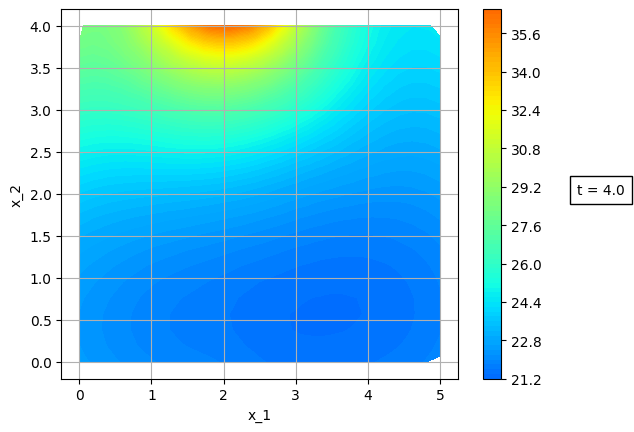

In [28]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=Omega, n_points=600, data_for_other_variables={'t':4.})
fig          = tp.utils.plot(model, lambda u : u,
                             plot_sampler, plot_type='contour_surface',
                             vmin=vmin, vmax=vmax)

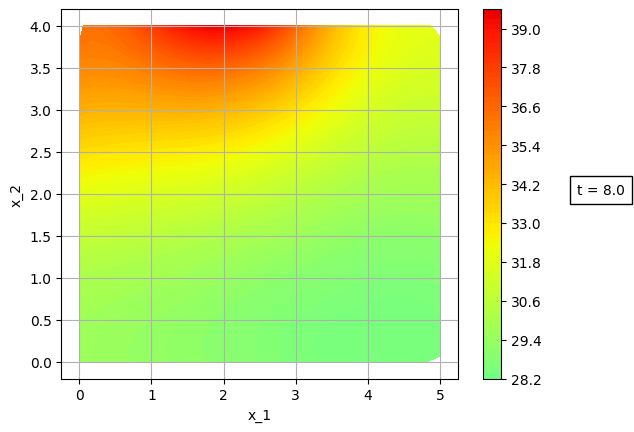

In [29]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=Omega, n_points=600, data_for_other_variables={'t':8.})
fig          = tp.utils.plot(model, lambda u : u,
                             plot_sampler, plot_type='contour_surface',
                            vmin=vmin, vmax=vmax)

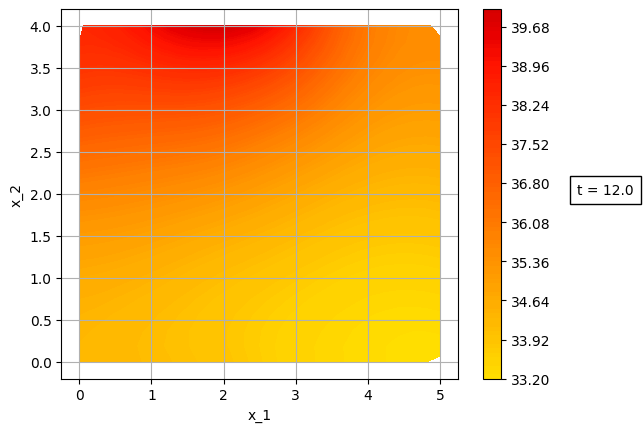

In [30]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=Omega, n_points=600, data_for_other_variables={'t':12.})
fig          = tp.utils.plot(model, lambda u : u, plot_sampler, plot_type='contour_surface',
                             vmin=vmin, vmax=vmax)

## Manual Visualization

It is also possible to evaluate the model manually at torch Tensors. Say, we want to evaluate it on a spatial grid at some fixed time $t'= 6$.

In [31]:
x_coords = torch.linspace(0, 5, 100)
y_coords = torch.linspace(0, 4, 80)
t_coords = torch.linspace(6, 6 , 1)

xs, ys, ts = torch.meshgrid([x_coords, y_coords, t_coords])
tensors = torch.stack([xs.flatten(), ys.flatten(), ts.flatten()], dim=1)

The TorchPhysics model cannot be directly evaluated at Pytorch Tensors. Tensors must first be transformed into TorchPhysics Points, which is easy to achieve. We only need to which space the "tensors" above belong to. In our case, it belongs to the space $X*T$. ATTENTION: Since the spatial coordinates have been fed into "tensors" first, it is important to define the space as $X*T$ and NOT $T*X$!
For more information on the Point class please have a look at the [space- and point-tutorial](https://boschresearch.github.io/torchphysics/tutorial/tutorial_spaces_and_points.html).

In [32]:
points = tp.spaces.Points(tensors, space=X*T)

Now the model can be evaluated at those points by its forward() method. In order to use e.g. "plt.imshow()", we need to transform the output into a numpy array.

In [33]:
output = model.forward(tp.spaces.Points(tensors, space=X*T))
output = output.as_tensor.reshape(100, 80, 1).detach().numpy()

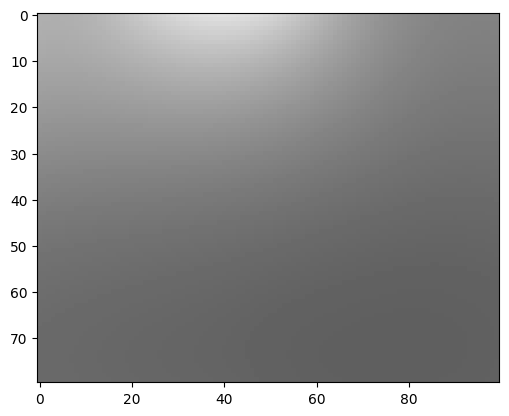

In [34]:
plt.imshow(np.rot90(output[:, :]), 'gray', vmin=vmin, vmax=vmax)
plt.show()